## Exctracting datas

In [135]:
# import
import sqlite3
import settings as s
import os
import pandas as pd
import numpy as n
import matplotlib.pyplot as plt
import seaborn as sns

In [136]:
# Extracting all datas
def get_constraints_from_db(db_path):
    conn = sqlite3.connect(db_path)
    cursor = conn.cursor()
    cursor.execute("SELECT * FROM ClassificationConstraints LIMIT 1")
    row = cursor.fetchone()
    conn.close()

    if not row:
        raise ValueError("Aucune contrainte trouvée dans la table.")

    columns = [
        "id", "min_size", "max_size", "min_height", "max_height", "min_width", "max_width",
        "min_avg_r", "max_avg_r", "min_avg_g", "max_avg_g", "min_avg_b", "max_avg_b",
        "min_contrast", "max_contrast", "min_edges", "max_edges"
    ]
    return dict(zip(columns, row))

def get_image_from_db(db_path, with_label=False):
    conn = sqlite3.connect(db_path)
    cursor = conn.cursor()
    query = "SELECT * FROM Image"

    if (with_label):
        query="SELECT * FROM Image WHERE File_path LIKE 'train/with_label/%' "
    cursor.execute(query)
    rows = cursor.fetchall()
    conn.close()

    rows = n.transpose(rows)

    columns = [
        "id_image", "File_name", "File_path", "Size", "Height", "Width",
        "Date_taken", "Avg_R", "Avg_G", "Avg_B",
        "Contrast_level", "RGB_Histogram", "Luminance_Histogram", "Edges","Status"
    ]
    return dict(zip(columns, rows))

db_path = os.path.join(s.BASE_DIR, "db.sqlite3")

image_data = get_image_from_db(db_path, True)

constraints = get_constraints_from_db(db_path)


In [137]:
image_data = pd.DataFrame(image_data)
image_data.head(5)

,id_image,File_name,File_path,Size,Height,Width,Date_taken,Avg_R,Avg_G,Avg_B,Contrast_level,RGB_Histogram,Luminance_Histogram,Edges,Status
0,661,WhatsApp Image 2020-05-09 at 2.03.38 PM (1).webp,train/with_label/clean/WhatsApp Image 2020-05-...,67.45,748,600,2025-06-23,127.3048462566845,127.7323774509804,135.81869875222816,52.67915025354561,"{""red"": [192.0, 152.0, 142.0, 194.0, 198.0, 17...","[75.0, 179.0, 259.0, 208.0, 243.0, 226.0, 211....",35024,0
1,662,00543_02.webp,train/with_label/clean/00543_02.webp,68.59,600,600,2025-05-28,117.64363055555556,117.13026666666667,116.23090555555557,49.74436375617508,"{""red"": [30.0, 13.0, 14.0, 19.0, 18.0, 39.0, 5...","[2.0, 9.0, 9.0, 10.0, 11.0, 16.0, 24.0, 31.0, ...",48342,0
2,663,WhatsApp Image 2020-05-09 at 2.03.38 PM (3).webp,train/with_label/clean/WhatsApp Image 2020-05-...,51.21,323,600,2025-06-03,129.3281475748194,120.54814241486069,110.3121826625387,63.47775687047143,"{""red"": [24.0, 21.0, 17.0, 29.0, 45.0, 45.0, 5...","[11.0, 80.0, 66.0, 61.0, 87.0, 112.0, 194.0, 1...",42723,0
3,664,WhatsApp Image 2020-05-09 at 2.03.37 PM (6).webp,train/with_label/clean/WhatsApp Image 2020-05-...,23.9,449,600,2025-06-13,129.29189680772086,126.69398292501856,115.66496288047513,42.847949274806794,"{""red"": [0.0, 1.0, 0.0, 2.0, 3.0, 4.0, 9.0, 2....","[0.0, 2.0, 10.0, 13.0, 7.0, 11.0, 7.0, 25.0, 2...",17213,0
4,665,00547_06.webp,train/with_label/clean/00547_06.webp,71.62,600,600,2025-06-04,114.25034722222223,113.7228,109.109825,49.01848935842701,"{""red"": [26.0, 12.0, 9.0, 20.0, 19.0, 43.0, 36...","[2.0, 7.0, 4.0, 5.0, 13.0, 13.0, 23.0, 34.0, 3...",49823,0


In [138]:
constraints

{'id': 1,
 'min_size': 0.0,
 'max_size': 5000.0,
 'min_height': 0,
 'max_height': 5000,
 'min_width': 0,
 'max_width': 5000,
 'min_avg_r': 0.0,
 'max_avg_r': 255.0,
 'min_avg_g': 0.0,
 'max_avg_g': 255.0,
 'min_avg_b': 0.0,
 'max_avg_b': 255.0,
 'min_contrast': 0.0,
 'max_contrast': 1.0,
 'min_edges': 0,
 'max_edges': 10000}

In [139]:
import json
import pandas as pd

# Fonction qui prend la chaîne JSON et renvoie les indices max
def extract_max_indices(hist_str):
    if pd.isna(hist_str):
        return pd.Series([None, None, None], index=["Max_Red_Index", "Max_Green_Index", "Max_Blue_Index"])
    
    hist = json.loads(hist_str)
    r = max(enumerate(hist["red"]), key=lambda x: x[1])[0]
    g = max(enumerate(hist["green"]), key=lambda x: x[1])[0]
    b = max(enumerate(hist["blue"]), key=lambda x: x[1])[0]
    return pd.Series([r, g, b], index=["Max_Red_Index", "Max_Green_Index", "Max_Blue_Index"])

# Application de la fonction sur toute la colonne
image_data[["Max_Red_Index", "Max_Green_Index", "Max_Blue_Index"]] = image_data["RGB_Histogram"].apply(extract_max_indices)


In [140]:
# Convertir les colonnes en float avant la somme pour éviter la concaténation de chaînes
image_data["sum_rgb"] = image_data[["Avg_R", "Avg_G", "Avg_B"]].astype(float).sum(axis=1)
image_data.drop(columns=["id_image", "File_name", "File_path", "Date_taken", "RGB_Histogram", "Luminance_Histogram", "Height", "Width"], inplace=True)

In [141]:
image_data = image_data.astype(float)

In [142]:
image_empty = image_data[image_data["Status"]==0]
image_full = image_data[image_data["Status"]==1]

In [143]:
image_empty

,Size,Avg_R,Avg_G,Avg_B,Contrast_level,Edges,Status,Max_Red_Index,Max_Green_Index,Max_Blue_Index,sum_rgb
0,67.45,127.304846,127.732377,135.818699,52.679150,35024.0,0.0,136.0,121.0,255.0,390.855922
1,68.59,117.643631,117.130267,116.230906,49.744364,48342.0,0.0,108.0,104.0,103.0,351.004803
2,51.21,129.328148,120.548142,110.312183,63.477757,42723.0,0.0,255.0,255.0,111.0,360.188473
3,23.90,129.291897,126.693983,115.664963,42.847949,17213.0,0.0,103.0,99.0,98.0,371.650843
4,71.62,114.250347,113.722800,109.109825,49.018489,49823.0,0.0,103.0,107.0,112.0,337.082972
5,82.88,116.279930,114.280882,114.431877,64.878854,62421.0,0.0,255.0,255.0,255.0,344.992689
6,69.07,122.386572,127.302589,121.965289,56.431535,43440.0,0.0,116.0,120.0,119.0,371.654450
7,28.85,111.080030,111.900614,105.170648,53.863528,10868.0,0.0,255.0,255.0,255.0,328.151292
8,57.77,122.540070,121.577120,120.122662,39.285750,23490.0,0.0,144.0,145.0,159.0,364.239852
9,48.39,130.774884,119.738655,111.431787,65.330094,33959.0,0.0,255.0,255.0,255.0,361.945326


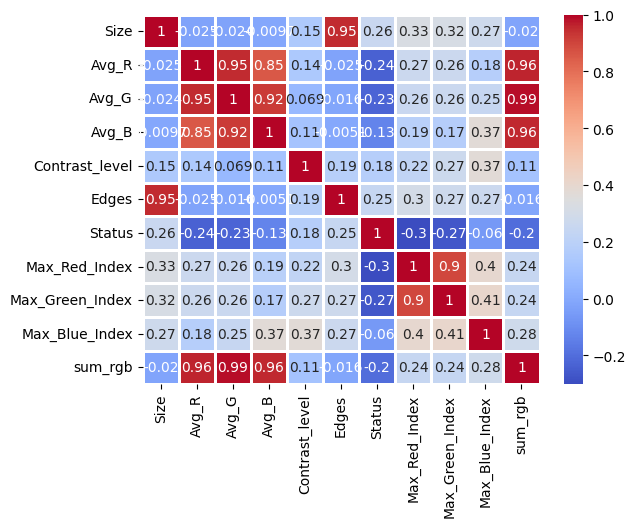

In [144]:
corr = image_data.corr ()
sns.heatmap(corr, cmap='coolwarm', annot = True, linewidth =0.9)
plt.show()

**Analyse :** On va utiliser les variables avec une correlation superieure à 0.2 

## Rules Tuning

In [145]:
def fit_polynomial(df, x_col, y_col, degree=2):
    """
    Ajuste une régression polynomiale sur tout le DataFrame et renvoie une fonction polynomiale utilisable.
    
    Args:
        df (pd.DataFrame): Tableau avec les données.
        x_col (str): Nom de la colonne x.
        y_col (str): Nom de la colonne y.
        degree (int): Degré du polynôme.
        
    Returns:
        np.poly1d: La fonction polynomiale.
    """
    coefs = n.polyfit(df[x_col], df[y_col], deg=degree)
    poly_fn = n.poly1d(coefs)
    return poly_fn


### Edges

In [147]:
s = {
    'count': image_empty["Edges"].count(),
    'min': image_empty["Edges"].min(),
    'max': image_empty["Edges"].max(),
    'median': image_empty["Edges"].median(),
    'mean': image_empty["Edges"].mean(),
    'std': image_empty["Edges"].std()
}

print("Edges - Empty")
for key, value in s.items():
    print(f"{key.capitalize():<8}: {value}")

s = {
    'count': image_full["Edges"].count(),
    'min': image_full["Edges"].min(),
    'max': image_full["Edges"].max(),
    'median': image_full["Edges"].median(),
    'mean': image_full["Edges"].mean(),
    'std': image_full["Edges"].std()
}

print("\nEdges - Full")
for key, value in s.items():
    print(f"{key.capitalize():<8}: {value}")


Edges - Empty
Count   : 20
Min     : 10868.0
Max     : 123955.0
Median  : 40885.0
Mean    : 42711.05
Std     : 24430.171060596364

Edges - Full
Count   : 20
Min     : 5876.0
Max     : 2012176.0
Median  : 41290.5
Mean    : 200637.45
Std     : 450695.9001746749


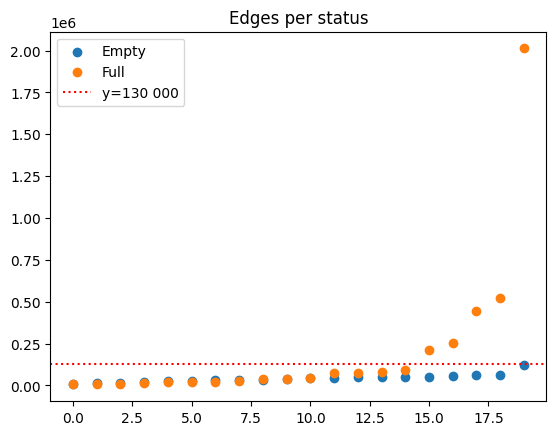

In [148]:
# Conversion des colonnes "Edges" en float pour le tri et le tracé
edges_empty = image_empty["Edges"].astype(float)
edges_full = image_full["Edges"].astype(float)

plt.scatter(n.arange(len(edges_empty)), sorted(edges_empty), label="Empty")
plt.scatter(n.arange(len(edges_full)), sorted(edges_full), label="Full")
plt.axhline(y=130000, color='red', linestyle=':', label='y=130 000')
plt.title("Edges per status")
plt.legend()
plt.show()

### Size

In [149]:
s = {
    'count': image_full["Size"].count(),
    'min': image_full["Size"].min(),
    'max': image_full["Size"].max(),
    'median': image_full["Size"].median(),
    'mean': image_full["Size"].mean(),
    'std': image_full["Size"].std()
}
print("Size - Full")
for key, value in s.items():
    print(f"{key.capitalize():<8}: {value}")

s = {
    'count': image_empty["Size"].count(),
    'min': image_empty["Size"].min(),
    'max': image_empty["Size"].max(),
    'median': image_empty["Size"].median(),
    'mean': image_empty["Size"].mean(),
    'std': image_empty["Size"].std()
}
print("Size - Empty")
for key, value in s.items():
    print(f"{key.capitalize():<8}: {value}")


Size - Full
Count   : 20
Min     : 20.95
Max     : 6458.14
Median  : 68.98
Mean    : 730.794
Std     : 1524.2758680812135
Size - Empty
Count   : 20
Min     : 23.9
Max     : 1821.85
Median  : 63.870000000000005
Mean    : 152.734
Std     : 394.35618312970774


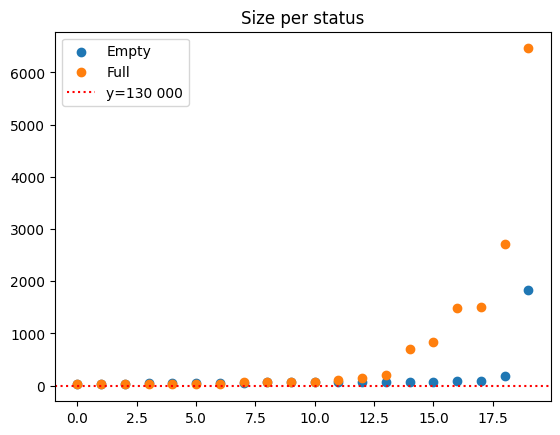

In [150]:
# Conversion des colonnes "Edges" en float pour le tri et le tracé
size_empty = image_empty["Size"].astype(float)
size_full = image_full["Size"].astype(float)

plt.scatter(n.arange(len(size_empty)), sorted(size_empty), label="Empty")
plt.scatter(n.arange(len(size_full)), sorted(size_full), label="Full")
plt.axhline(y=0, color='red', linestyle=':', label='y=130 000')
plt.title("Size per status")
plt.legend()
plt.show()

## Model

In [151]:
def classify(image):
    # En plus : appliquer un filtre de jour pour les images de nuit

    score = 0
    if(image["Edges"] >= 123955):
        score+=1
    
    

    return 1 if(score > 5) else 0     # 1 pour full
    if(score > 5):
        ret
